#Building Models for the IMDB Reviews Dataset

Here, we will build four models and train it on the IMDB Reviews dataset with full word encoding. These use different layers after the embedding namely Flatten, LSTM, GRU, and Conv1D. We will compare the performance and see which architecture might be best for this particular dataset

Outline:
1. Import
2. Download and Prepare the Dataset
3. Model 1: Flatten
4. Model 2: LSTM
5. Model 3: GRU
6. Model 4: Convolution


###Imports
We will first import common libraries that will be used throughout the notebook.

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

###Download and Prepare the Dataset

Next, we will download the plain_text version of the IMDB Reviews dataset.

In [ ]:
# Download the plain text dataset
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteR5AOJV/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteR5AOJV/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteR5AOJV/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# Get the train and test sets
train_data, test_data = imdb['train'], imdb['test']

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())

# Loop over all test examples and save the sentences and labels
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())

# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

Unlike the subword encoded set, we will need to build the vocabulary from scratch and generate padded sequences. 


In [ ]:
# Parameters
vocab_size = 10000
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

Plot Utility
Before we define the models, we will define the function below so we can easily visualize the accuracy and loss history after training.



In [ ]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

##Model 1: Flatten

First up is simply using a Flatten layer after the embedding. Its main advantage is that it is very fast to train. Observe the results below.



In [ ]:
# Parameters
embedding_dim = 16
dense_dim = 6

# Model Definition with a Flatten layer
model_flatten = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_flatten.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_flatten.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 6)                 11526     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [ ]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_flatten = model_flatten.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 3s 10ms/step - loss: 0.6199 - accuracy: 0.6491 - val_loss: 0.4117 - val_accuracy: 0.8306
Epoch 2/10
196/196 [==============================] - 2s 9ms/step - loss: 0.3275 - accuracy: 0.8661 - val_loss: 0.3365 - val_accuracy: 0.8553
Epoch 3/10
196/196 [==============================] - 2s 9ms/step - loss: 0.2061 - accuracy: 0.9277 - val_loss: 0.3493 - val_accuracy: 0.8480
Epoch 4/10
196/196 [==============================] - 1s 7ms/step - loss: 0.1180 - accuracy: 0.9691 - val_loss: 0.4033 - val_accuracy: 0.8342
Epoch 5/10
196/196 [==============================] - 1s 7ms/step - loss: 0.0568 - accuracy: 0.9914 - val_loss: 0.4561 - val_accuracy: 0.8295
Epoch 6/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0275 - accuracy: 0.9976 - val_loss: 0.4782 - val_accuracy: 0.8319
Epoch 7/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0147 - accuracy: 0.9991 - val_loss: 0.5221 - val_accuracy: 0.8296
Epoch

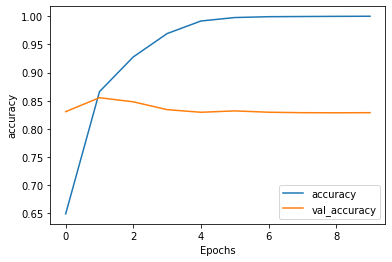

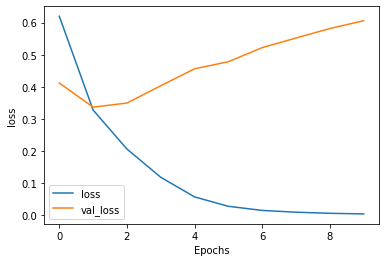

In [ ]:
# Plot the accuracy and loss history
plot_graphs(history_flatten, 'accuracy')
plot_graphs(history_flatten, 'loss')

##Model 2: LSTM
Next, we will use an LSTM. This is slower to train but useful in applications where the order of the tokens is important.



In [ ]:
# Parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 6

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [ ]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_lstm = model_lstm.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))


Epoch 1/10
196/196 [==============================] - 33s 152ms/step - loss: 0.5537 - accuracy: 0.6985 - val_loss: 0.3995 - val_accuracy: 0.8261
Epoch 2/10
196/196 [==============================] - 29s 147ms/step - loss: 0.3259 - accuracy: 0.8670 - val_loss: 0.3697 - val_accuracy: 0.8422
Epoch 3/10
196/196 [==============================] - 29s 150ms/step - loss: 0.2585 - accuracy: 0.9018 - val_loss: 0.3673 - val_accuracy: 0.8419
Epoch 4/10
196/196 [==============================] - 27s 140ms/step - loss: 0.2119 - accuracy: 0.9251 - val_loss: 0.4091 - val_accuracy: 0.8322
Epoch 5/10
196/196 [==============================] - 33s 169ms/step - loss: 0.1846 - accuracy: 0.9369 - val_loss: 0.4812 - val_accuracy: 0.8253
Epoch 6/10
196/196 [==============================] - 31s 159ms/step - loss: 0.1618 - accuracy: 0.9453 - val_loss: 0.4705 - val_accuracy: 0.8196
Epoch 7/10
196/196 [==============================] - 27s 139ms/step - loss: 0.1439 - accuracy: 0.9540 - val_loss: 0.5013 - val_ac

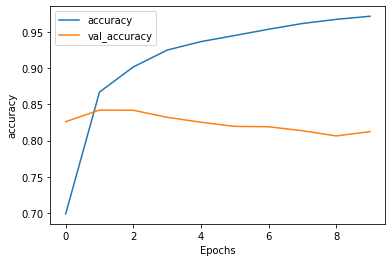

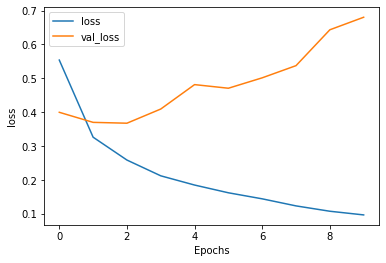

In [ ]:
# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

##Model 3: GRU
The Gated Recurrent Unit or GRU is usually referred to as a simpler version of the LSTM. It can be used in applications where the sequence is important but we want faster results and can sacrifice some accuracy. We will notice in the model summary that it is a bit smaller than the LSTM and it also trains faster by a few seconds.



In [ ]:
import tensorflow as tf

# Parameters
embedding_dim = 16
gru_dim = 32
dense_dim = 6

# Model Definition with GRU
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               9600      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [ ]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_gru = model_gru.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))


Epoch 1/10
196/196 [==============================] - 28s 128ms/step - loss: 0.5875 - accuracy: 0.6518 - val_loss: 0.4070 - val_accuracy: 0.8146
Epoch 2/10
196/196 [==============================] - 26s 131ms/step - loss: 0.3250 - accuracy: 0.8654 - val_loss: 0.3708 - val_accuracy: 0.8340
Epoch 3/10
196/196 [==============================] - 26s 132ms/step - loss: 0.2496 - accuracy: 0.9024 - val_loss: 0.4271 - val_accuracy: 0.8416
Epoch 4/10
196/196 [==============================] - 26s 135ms/step - loss: 0.2126 - accuracy: 0.9200 - val_loss: 0.4075 - val_accuracy: 0.8355
Epoch 5/10
196/196 [==============================] - 26s 130ms/step - loss: 0.1793 - accuracy: 0.9360 - val_loss: 0.4313 - val_accuracy: 0.8345
Epoch 6/10
196/196 [==============================] - 26s 132ms/step - loss: 0.1534 - accuracy: 0.9461 - val_loss: 0.4467 - val_accuracy: 0.8281
Epoch 7/10
196/196 [==============================] - 26s 131ms/step - loss: 0.1279 - accuracy: 0.9558 - val_loss: 0.5158 - val_ac

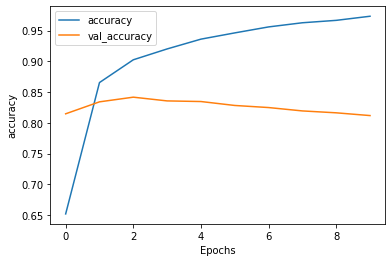

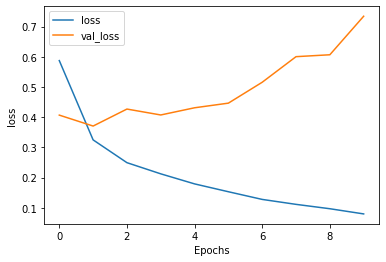

In [ ]:
# Plot the accuracy and loss history
plot_graphs(history_gru, 'accuracy')
plot_graphs(history_gru, 'loss')


##Model 4: Convolution
Lastly, we use a convolution layer to extract features from our dataset. We will append a GlobalAveragePooling1d layer to reduce the results before passing it on to the dense layers. Like the model with Flatten, this also trains much faster than the ones using RNN layers like LSTM and GRU.


In [ ]:
# Parameters
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_6 (Dense)             (None, 6)                 774       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
________________________________________________

In [ ]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_conv = model_conv.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))


Epoch 1/10
196/196 [==============================] - 9s 40ms/step - loss: 0.5422 - accuracy: 0.7164 - val_loss: 0.3613 - val_accuracy: 0.8432
Epoch 2/10
196/196 [==============================] - 8s 39ms/step - loss: 0.3052 - accuracy: 0.8739 - val_loss: 0.3446 - val_accuracy: 0.8501
Epoch 3/10
196/196 [==============================] - 8s 40ms/step - loss: 0.2437 - accuracy: 0.9035 - val_loss: 0.3643 - val_accuracy: 0.8448
Epoch 4/10
196/196 [==============================] - 8s 40ms/step - loss: 0.2093 - accuracy: 0.9209 - val_loss: 0.3992 - val_accuracy: 0.8390
Epoch 5/10
196/196 [==============================] - 8s 40ms/step - loss: 0.1810 - accuracy: 0.9337 - val_loss: 0.4346 - val_accuracy: 0.8320
Epoch 6/10
196/196 [==============================] - 8s 39ms/step - loss: 0.1594 - accuracy: 0.9432 - val_loss: 0.4766 - val_accuracy: 0.8255
Epoch 7/10
196/196 [==============================] - 8s 40ms/step - loss: 0.1389 - accuracy: 0.9526 - val_loss: 0.5232 - val_accuracy: 0.8204

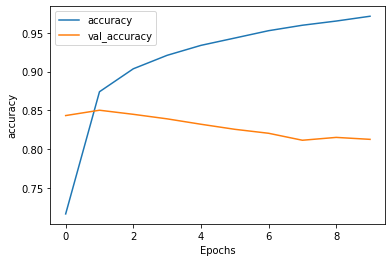

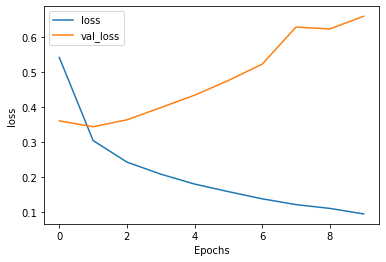

In [ ]:
# Plot the accuracy and loss history
plot_graphs(history_conv, 'accuracy')
plot_graphs(history_conv, 'loss')


* All the models were run 10 epochs.
* As per time taken (step/ms): Flatten < Convolution < GRU < LSTM
* For this dataset and the setting, each model shows a similar result.